In [1]:
%reset -f
%matplotlib notebook
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

import networkx as nx

from aux import Generic, GenericFlexible
from ntwk import LIFNtwk
from disp import raster, set_font_size

# Scale-free graphs

In [2]:
def directed_power_law_adj(n, gamma):
    """
    Construct an adjacency matrix with equal but uncorrelated power-law
    in- and out-degree distributions.
    """
    deg_possible = np.arange(n, dtype=float)
    
    # get normalized power-law probability over deg_possible
    p_unnormed = (deg_possible + 1) ** (-gamma)
    p_normed = p_unnormed / np.sum(p_unnormed)
    
    # sample in-deg from power-law distribution
    in_deg = np.random.choice(deg_possible.astype(int), n, replace=True, p=p_normed)
    
    # shuffle out-deg to break corr. with in-deg
    out_deg = in_deg[np.random.permutation(n)]
    
    g = nx.directed_configuration_model(in_deg, out_deg, create_using=nx.DiGraph())
    
    adj = np.array(nx.adjacency_matrix(g, weight=None).T.todense())
    np.fill_diagonal(adj, 0)
    
    return adj.astype(bool)

<IPython.core.display.Javascript object>


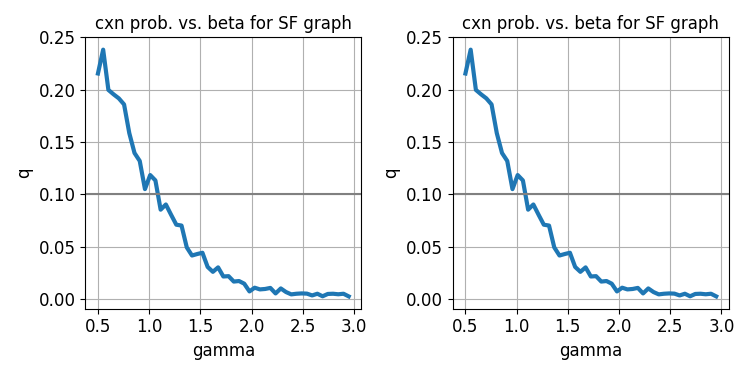

In [3]:
SEED = 0
N = 100

np.random.seed(SEED)

gammas = np.linspace(0.5, 3)[:-1]
qs = np.nan * np.zeros(gammas.shape)

for ctr, gamma in enumerate(gammas):
    
    # get cxn prob
    c_rcr = directed_power_law_adj(N, gamma)
    q = c_rcr.sum() / (N*(N-1))
    
    qs[ctr] = q
    
fig, axs = plt.subplots(1, 2, figsize=(7.5, 3.75), tight_layout=True)

for ax in axs:
    ax.plot(gammas, qs, lw=3)
    ax.axhline(.1, color='gray')
    ax.set_xlabel('gamma')
    ax.set_ylabel('q')
    ax.set_title('cxn prob. vs. beta for SF graph')
    
    ax.grid()

    set_font_size(ax, 12)

# Scale-free LIF network

In [4]:
def sf_ntwk(P, STORE=None):
    """Make a new LIF ntwk with scale-free connectivity."""
    # make upstream weight matrix
    ws_up = {'E': P.w_e_up * np.eye(P.n)}
    
    c_rcr = directed_power_law_adj(P.n, P.gamma)
    
    # remake graph
    g = nx.from_numpy_matrix(c_rcr.T, create_using=nx.DiGraph())
    
    # set weights
    ws_rcr = {'E': P.w_e_rcr * c_rcr}
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=np.repeat(P.t_m, P.n),
        e_l=np.repeat(P.e_l, P.n),
        v_th=np.repeat(P.v_th, P.n),
        v_reset=np.repeat(P.v_reset, P.n),
        t_r=np.repeat(P.t_r, P.n),
        es_syn={'E': P.e_e},
        ts_syn={'E': P.t_e},
        ws_rcr=ws_rcr,
        ws_up=ws_up)
    
    STORE.g = g
    STORE.c_rcr = c_rcr.copy()
    STORE.ws_rcr = ws_rcr.copy()
    
    return ntwk, STORE

In [5]:
def run(ntwk, P, STORE=None):
    """Construct SF ntwk and run smln."""
    
    # make noisy input
    t = np.arange(0, P.dur, P.dt)
    spks_up = np.random.poisson(P.frq_up * P.dt, (len(t), P.n))
    spks_up[t >= P.stm_off] = 0
    
    # run ntwk
    rsp = ntwk.run(spks_up, P.dt)
    
    STORE.spks_up = spks_up.copy()
    
    return rsp, STORE

## Reasonable parameters

<IPython.core.display.Javascript object>


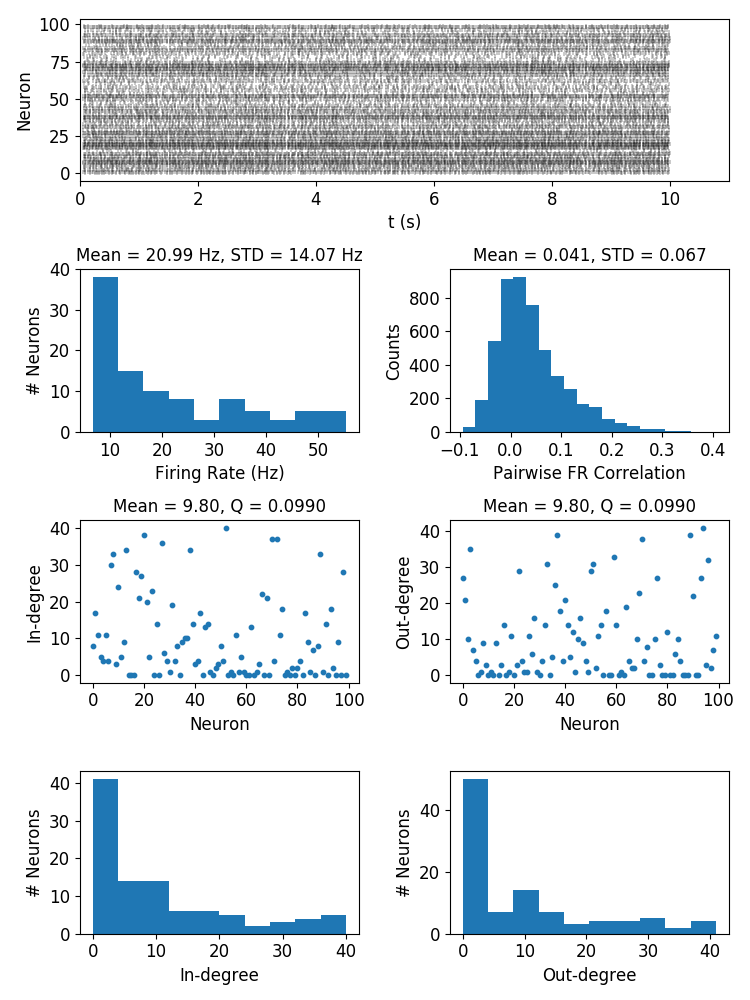

In [7]:
np.random.seed(0)

P = Generic(
    # general
    dt=0.0005,
    
    # ntwk
    n=100,
    gamma=1,
    t_m=0.05,
    e_l=-0.068,
    v_th=-0.036,
    v_reset=-.068,
    t_r=0.002,
    e_e=0,
    t_e=0.002,
    w_e_rcr=0.01,  # 0 for no recurrence
    w_e_up=0.01,
    
    # input
    frq_up=400,  # 600 for no recurrence
    stm_off=10,
    
    # smln
    dur=11)

STORE = GenericFlexible()

ntwk = sf_ntwk(P, STORE)[0]
rsp = run(ntwk, P, STORE)[0]

# make plots
gs = gridspec.GridSpec(4, 2)
fig = plt.figure(figsize=(7.5, 10), tight_layout=True)
axs = []

# raster
axs.append(fig.add_subplot(gs[0, :]))
raster(axs[-1], rsp.ts, rsp.spks)

# firing rate distribution
axs.append(fig.add_subplot(gs[1, 0]))

t_wdw = 0.2, 10
t_mask = (t_wdw[0] <= rsp.ts) & (rsp.ts < t_wdw[1])
fr = rsp.spks[t_mask, :].sum(0) / (t_wdw[1] - t_wdw[0])
axs[-1].hist(fr)
axs[-1].set_xlabel('Firing Rate (Hz)')
axs[-1].set_ylabel('# Neurons')
axs[-1].set_title('Mean = {0:.2f} Hz, STD = {1:.2f} Hz'.format(fr.mean(), fr.std()))

# correlation distribution
axs.append(fig.add_subplot(gs[1, 1]))

t_bin_size = 0.01
t_bins = np.arange(t_wdw[0], t_wdw[1]+t_bin_size, t_bin_size)

spk_cts = []
for t_bin_start, t_bin_end in zip(t_bins[:-1], t_bins[1:]):
    t_bin_mask = (t_bin_start <= rsp.ts) & (rsp.ts < t_bin_end)
    spks_t_bin = rsp.spks[t_bin_mask, :]
    spk_cts.append(spks_t_bin.sum(0))
    
corrs = np.corrcoef(spk_cts, rowvar=False)
corrs = corrs[np.triu_indices(P.n, 1)]

axs[-1].hist(corrs, bins=20)
axs[-1].set_xlabel('Pairwise FR Correlation')
axs[-1].set_ylabel('Counts')
axs[-1].set_title('Mean = {0:.3f}, STD = {1:.3f}'.format(corrs.mean(), corrs.std()))

# in & out-degree distributions
axs.append(fig.add_subplot(gs[2, 0]))
cells = np.arange(P.n)
in_degs = [STORE.g.in_degree(cell) for cell in cells]
axs[-1].scatter(cells, in_degs, s=10)
axs[-1].set_xlabel('Neuron')
axs[-1].set_ylabel('In-degree')
axs[-1].set_title('Mean = {0:.2f}, Q = {1:.4f}'.format(
    np.mean(in_degs), np.mean(in_degs)/(P.n - 1)))

axs.append(fig.add_subplot(gs[2, 1]))
cells = np.arange(P.n)
out_degs = [STORE.g.out_degree(cell) for cell in cells]
axs[-1].scatter(cells, out_degs, s=10)
axs[-1].set_xlabel('Neuron')
axs[-1].set_ylabel('Out-degree')
axs[-1].set_title('Mean = {0:.2f}, Q = {1:.4f}'.format(
    np.mean(out_degs), np.mean(out_degs)/(P.n - 1)))

axs.append(fig.add_subplot(gs[3, 0]))
axs[-1].hist(in_degs, bins=10)
axs[-1].set_xlabel('In-degree')
axs[-1].set_ylabel('# Neurons')

axs.append(fig.add_subplot(gs[3, 1]))
axs[-1].hist(out_degs, bins=10)
axs[-1].set_xlabel('Out-degree')
axs[-1].set_ylabel('# Neurons')

for ax in axs:
    set_font_size(ax, 12)